In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
from nltk.corpus import stopwords
from nltk import PorterStemmer as Stemmer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, f1_score

In [85]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [40]:
df = pd.read_csv('email_data.csv')
print(df.head())

                                             message category
0  Go until jurong point, crazy.. Available only ...      ham
1                      Ok lar... Joking wif u oni...      ham
2  Free entry in 2 a wkly comp to win FA Cup fina...     junk
3  U dun say so early hor... U c already then say...      ham
4  Nah I don't think he goes to usf, he lives aro...      ham


In [41]:
print("Number of rows are: ",df.shape[0])
print("Number of columns are: ",df.shape[1])
df.info()

Number of rows are:  10572
Number of columns are:  2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10572 entries, 0 to 10571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   message   10564 non-null  object
 1   category  10572 non-null  object
dtypes: object(2)
memory usage: 165.3+ KB


In [42]:
duplicates_text = df[df['message'].duplicated()]
duplicates_all = df[df.duplicated()]

print(duplicates_text.shape)
print(duplicates_all.shape)
print(df['category'].unique())

(625, 2)
(624, 2)
['ham' 'junk']


In [43]:
df = df.drop_duplicates().reset_index(drop=True)
print(df)

                                                message category
0     Go until jurong point, crazy.. Available only ...      ham
1                         Ok lar... Joking wif u oni...      ham
2     Free entry in 2 a wkly comp to win FA Cup fina...     junk
3     U dun say so early hor... U c already then say...      ham
4     Nah I don't think he goes to usf, he lives aro...      ham
...                                                 ...      ...
9943  I noticed a drop in checks, and did some tests...      ham
9944  >>>>> "U" == Udhay Shankar N  writes:    U> At...      ham
9945  i will be out next week imbalances : i would l...      ham
9946  re : first delivery - wagner oil vance , deal ...      ham
9947  Once upon a time, Peter wrote :> On Fri, Feb 0...      ham

[9948 rows x 2 columns]


Dataset gồm 2 cột Message : Label (Ham/Junk)
Bao gồm

In [44]:
inconsistent = df.groupby('message')['category'].nunique()
conflicting_content = inconsistent[inconsistent > 1].index
conflict_records = df[df['message'].isin(conflicting_content)]
print(conflict_records)

     message category
5211   empty     junk
5263   empty      ham


In [45]:
print(df.isnull().sum())

message     1
category    0
dtype: int64


In [46]:
df_clean = df[df['message'].str.strip() != 'empty']
df_clean = df_clean.dropna()
df_clean['spam'] = df_clean['category'].apply(lambda x:1 if x=='junk' else 0)
print(df_clean)

                                                message category  spam
0     Go until jurong point, crazy.. Available only ...      ham     0
1                         Ok lar... Joking wif u oni...      ham     0
2     Free entry in 2 a wkly comp to win FA Cup fina...     junk     1
3     U dun say so early hor... U c already then say...      ham     0
4     Nah I don't think he goes to usf, he lives aro...      ham     0
...                                                 ...      ...   ...
9943  I noticed a drop in checks, and did some tests...      ham     0
9944  >>>>> "U" == Udhay Shankar N  writes:    U> At...      ham     0
9945  i will be out next week imbalances : i would l...      ham     0
9946  re : first delivery - wagner oil vance , deal ...      ham     0
9947  Once upon a time, Peter wrote :> On Fri, Feb 0...      ham     0

[9945 rows x 3 columns]


In [47]:
import string
from nltk.corpus import stopwords
from nltk import PorterStemmer as Stemmer
def process(text):
    # lowercase it
    text = text.lower()
    # remove punctuation
    text = ''.join([t for t in text if t not in string.punctuation])
    # remove stopwords
    text = [t for t in text.split() if t not in stopwords.words('english')]
    # stemming
    st = Stemmer()
    text = [st.stem(t) for t in text]
    # return token list
    return (text)

In [11]:
print(process("Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."))

['go', 'jurong', 'point', 'crazi', 'avail', 'bugi', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'got', 'amor', 'wat']


In [48]:
x_train, x_test, y_train, y_test = train_test_split(df_clean['message'], df_clean['spam'], test_size=0.25, random_state = 3)

In [49]:
tfidfv = TfidfVectorizer(max_df=0.9, min_df=5, analyzer=process)
x_train_vec = tfidfv.fit_transform(x_train)
x_test_vec = tfidfv.transform(x_test)

In [91]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline


alphas = np.linspace(0.01, 2.0, 20)
f1_scores = []
accuracy_scores = []

for alpha in alphas:
    model = make_pipeline(
        MultinomialNB(alpha=alpha)
    )

    # F1 macro
    f1 = cross_val_score(model, x_train_vec, y_train, cv=5, scoring='f1_macro')
    f1_scores.append(f1.mean())

    # Accuracy
    acc = cross_val_score(model, x_train_vec, y_train, cv=5, scoring='accuracy')
    accuracy_scores.append(acc.mean())

best_f1_idx = np.argmax(f1_scores)
best_acc_idx = np.argmax(accuracy_scores)

print(f"Alpha tốt nhất theo F1: {alphas[best_f1_idx]:.2f} (F1 = {f1_scores[best_f1_idx]:.4f})")
print(f"Alpha tốt nhất theo Accuracy: {alphas[best_acc_idx]:.2f} (Acc = {accuracy_scores[best_acc_idx]:.4f})")

Alpha tốt nhất theo F1: 0.11 (F1 = 0.9415)
Alpha tốt nhất theo Accuracy: 0.11 (Acc = 0.9576)


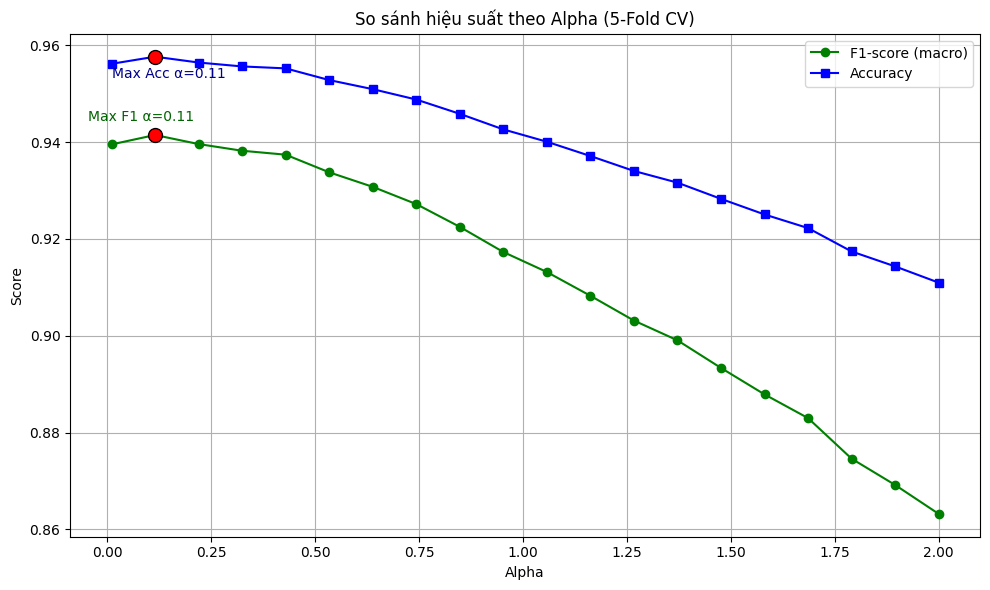

In [92]:
plt.figure(figsize=(10, 6))

plt.plot(alphas, f1_scores, marker='o', label='F1-score (macro)', color='green')
plt.plot(alphas, accuracy_scores, marker='s', label='Accuracy', color='blue')

#F1 cao nhất
plt.scatter(alphas[best_f1_idx], f1_scores[best_f1_idx], color='red', s=100, edgecolor='black', zorder=5)
plt.annotate(f'Max F1 α={alphas[best_f1_idx]:.2f}',
             (alphas[best_f1_idx], f1_scores[best_f1_idx]),
             textcoords="offset points", xytext=(-10,10), ha='center', color='darkgreen')

#Accuracy cao nhất
plt.scatter(alphas[best_acc_idx], accuracy_scores[best_acc_idx], color='red', s=100, edgecolor='black', zorder=5)
plt.annotate(f'Max Acc α={alphas[best_acc_idx]:.2f}',
             (alphas[best_acc_idx], accuracy_scores[best_acc_idx]),
             textcoords="offset points", xytext=(10,-15), ha='center', color='darkblue')

plt.title('So sánh hiệu suất theo Alpha (5-Fold CV)')
plt.xlabel('Alpha')
plt.ylabel('Score')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [95]:
spam_filter = MultinomialNB(alpha=alphas[best_f1_idx])
spam_filter.fit(x_train_vec, y_train)

predictions = spam_filter.predict(x_test_vec)

In [96]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97      1848
           1       0.94      0.85      0.89       639

    accuracy                           0.95      2487
   macro avg       0.94      0.92      0.93      2487
weighted avg       0.95      0.95      0.95      2487



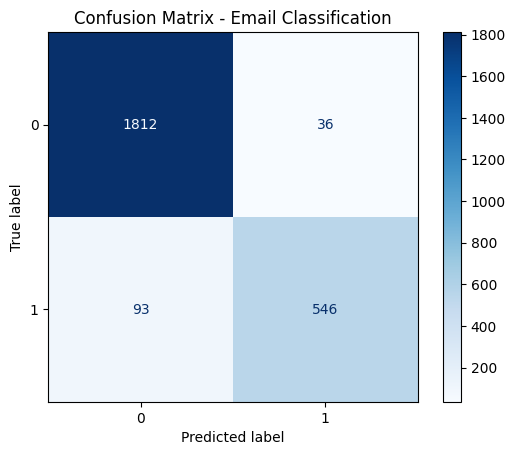

In [84]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, predictions, labels=[0, 1])

# Hiển thị
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0', '1'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Email Classification")
plt.show()
